In [15]:
# Data manipulation, refer: https://cienciadedatos.net/documentos/py29-forecasting-electricity-power-demand-python
# ==============================================================================
import numpy as np
import pandas as pd
# from astral.sun import sun
# from astral import LocationInfo
from skforecast.datasets import fetch_dataset
# Libraries
# ==============================================================================

# Plots
# ==============================================================================
import matplotlib.pyplot as plt

## This notebook use "Demand" and "Temperature", "Holiday" 3 features for prediction.
- We DO NOT rescale/normalize based on training dataset

## Refer to: https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html

In [16]:
data = fetch_dataset(name='vic_electricity', raw=True)
data.info()

vic_electricity
---------------
Half-hourly electricity demand for Victoria, Australia
O'Hara-Wild M, Hyndman R, Wang E, Godahewa R (2022).tsibbledata: Diverse
Datasets for 'tsibble'. https://tsibbledata.tidyverts.org/,
https://github.com/tidyverts/tsibbledata/.
https://tsibbledata.tidyverts.org/reference/vic_elec.html
Shape of the dataset: (52608, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         52608 non-null  object 
 1   Demand       52608 non-null  float64
 2   Temperature  52608 non-null  float64
 3   Date         52608 non-null  object 
 4   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 1.7+ MB


In [17]:
data.head()
## Verify that a temporary index is complete
# # ==============================================================================
# start_date = data.index.min()
# end_date = data.index.max()
# complete_date_range = pd.date_range(start=start_date, end=end_date, freq=data.index.freq)
# is_index_complete = (data.index == complete_date_range).all()
# print(f"Index complete: {is_index_complete}")
# print(f"Number of rows with missing values: {data.isnull().any(axis=1).mean()}")

,Time,Demand,Temperature,Date,Holiday
0,2011-12-31T13:00:00Z,4382.825174,21.40,2012-01-01,True
1,2011-12-31T13:30:00Z,4263.365526,21.05,2012-01-01,True
2,2011-12-31T14:00:00Z,4048.966046,20.70,2012-01-01,True
3,2011-12-31T14:30:00Z,3877.563330,20.55,2012-01-01,True
4,2011-12-31T15:00:00Z,4036.229746,20.40,2012-01-01,True


In [18]:
list(data.columns.values)

['Time', 'Demand', 'Temperature', 'Date', 'Holiday']

In [19]:
# Data preparation
# ==============================================================================
data = data.copy()
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%dT%H:%M:%SZ')
data = data.set_index('Time') # use time as index
data = data.asfreq('30min').ffill() # chunch as 30min time resolution and forward fill missing data
data = data.sort_index() # sort by time order
data.head(4)


,Demand,Temperature,Date,Holiday
Time,,,,
2011-12-31 13:00:00,4382.825174,21.40,2012-01-01,True
2011-12-31 13:30:00,4263.365526,21.05,2012-01-01,True
2011-12-31 14:00:00,4048.966046,20.70,2012-01-01,True
2011-12-31 14:30:00,3877.563330,20.55,2012-01-01,True


In [20]:
# Aggregating in 1H intervals
# ==============================================================================
# The Date column is eliminated so that it does not generate an error when aggregating.

data = (
    data
    .resample(rule="h", closed="left", label="right")
    .agg({
        "Demand": "mean",
        "Temperature": "mean",
        "Holiday": "mean",
    })
)
data.tail()

,Demand,Temperature,Holiday
Time,,,
2014-12-31 09:00:00,4069.625550,21.60,0.0
2014-12-31 10:00:00,3909.230704,20.30,0.0
2014-12-31 11:00:00,3900.600901,19.65,0.0
2014-12-31 12:00:00,3758.236494,18.10,0.0
2014-12-31 13:00:00,3785.650720,17.20,0.0


In [21]:
data["Num Holiday"] = data["Holiday"].astype(float) # convert holiday true false to numerical
df_DTH = data[['Demand','Temperature','Num Holiday']]
df_DTH

,Demand,Temperature,Num Holiday
Time,,,
2011-12-31 14:00:00,4323.095350,21.225,1.0
2011-12-31 15:00:00,3963.264688,20.625,1.0
2011-12-31 16:00:00,3950.913495,20.325,1.0
2011-12-31 17:00:00,3627.860675,19.850,1.0
2011-12-31 18:00:00,3396.251676,19.025,1.0
...,...,...,...
2014-12-31 09:00:00,4069.625550,21.600,0.0
2014-12-31 10:00:00,3909.230704,20.300,0.0
2014-12-31 11:00:00,3900.600901,19.650,0.0


### Below check the correlation between each variable using heatmap
- https://www.linkedin.com/pulse/time-series-episode-3-arima-forecasting-exogenous-vasilis-kalyvas-c09kf

<Axes: >

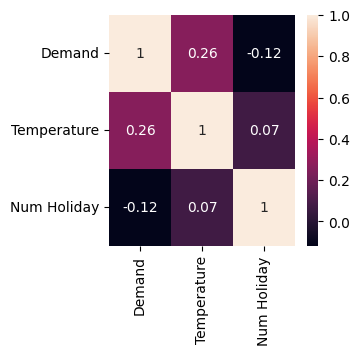

In [22]:
import seaborn as sns
# are these variables related to each other?
plt.figure(figsize=(3,3))
sns.heatmap(df_DTH.corr(), annot=True,)

### Below check the stationary of "Demand" and "Temperature" data
https://www.linkedin.com/pulse/time-series-episode-3-arima-forecasting-exogenous-vasilis-kalyvas-c09kf

### Idea:
- Null Hypothesis (H0): The Time Series has a unit root (non-stationary).
- Alternative Hypothesis (H1): The Time Series is stationary.
- If the p-value is less than a chosen significance level (e.g. 0.05), you reject the null hypothesis and consider that Time Series is stationary.

### If None-Stationay: 
Then use the difference value betweeen two time step instead of original value. refer to: https://otexts.com/fpp2/stationarity.html


In [23]:
# import the ADF test
from statsmodels.tsa.stattools import adfuller

# create a function that returns the necessary metrics to test stationarity
def test_stationarity(timeseries):
    dftest_initial = adfuller(timeseries)
    dfoutput_initial = pd.Series(dftest_initial[0:4], 
                                 index=['Statistical Test', 
                                        'p-value', 
                                        '#Lags used', 
                                        'Number of observations'
                                       ])
    
    for key, value in dftest_initial[4].items():
        dfoutput_initial['Critical value ' + key] = value
    
    print(dfoutput_initial)        

In [24]:
test_stationarity(data['Demand'])# --> p value <0.05 then demand is stationary

Statistical Test         -1.574664e+01
p-value                   1.237452e-28
#Lags used                4.900000e+01
Number of observations    2.625400e+04
Critical value 1%        -3.430599e+00
Critical value 5%        -2.861650e+00
Critical value 10%       -2.566829e+00
dtype: float64


In [25]:
test_stationarity(data['Temperature'])# --> p value <0.05 then temperature is stationary

Statistical Test         -1.072100e+01
p-value                   3.151111e-19
#Lags used                4.800000e+01
Number of observations    2.625500e+04
Critical value 1%        -3.430599e+00
Critical value 5%        -2.861650e+00
Critical value 10%       -2.566829e+00
dtype: float64


In [26]:
'''
Below is the code if you need to do a differencing in data frame to address non-stationary case
'''

# ts = data['Temperature'].copy()
# diff_ts = ts.diff()

# print(f'ts: {len(ts)}')
# print(f'diff_ts: {len(diff_ts)}')
# diff_ts

# # need to do a backward fill as the first row of the diff is NaN
# diff_ts.bfill()


'\nBelow is the code if you need to do a differencing in data frame to address non-stationary case\n'

### Compute Auto Correlation on stationary data

In [27]:
# import necessary modules
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# define function that returns the ACF and PACF plots for a given time series
def autocorrelation_plots(timeseries, description, n_lags):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plot_acf(timeseries, ax=plt.gca(), lags=n_lags)
    plt.title('Autocorrelation ({})'.format(description))
    plt.xlabel('Number of lags')
    plt.ylabel('correlation')
    plt.subplot(122)
    plot_pacf(timeseries, ax=plt.gca(), lags=n_lags)
    plt.title('Partial Autocorrelation ({})'.format(description))
    plt.xlabel('Number of lags')
    plt.ylabel('correlation')
    plt.show()   

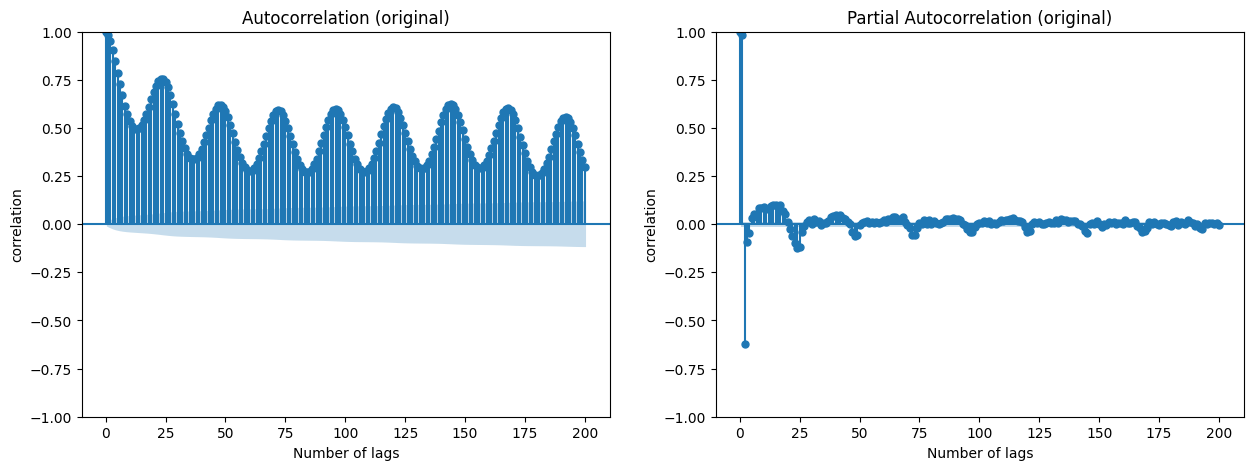

In [28]:
autocorrelation_plots(data['Temperature'], 'original', n_lags=200)

## Back testing for ML model (cross-validation for time series data)
- https://skforecast.org/0.1/guides/cross-validation-backtest
- to use multiple time series data for training forecaster, you need to call ``backtesting_forecaster_multiseries'' class
- To use multipel time series together fore prediction and then do back testing , see: https://skforecast.org/0.5.0/user_guides/multi-time-series-forecasting


In [29]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from skforecast.ForecasterAutoregMultiSeries import ForecasterAutoregMultiSeries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

from skforecast.model_selection_multiseries import grid_search_forecaster_multiseries
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
from skforecast.model_selection_multiseries import grid_search_forecaster_multivariate
from skforecast.model_selection_multiseries import backtesting_forecaster_multivariate

# regression type:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor


# Backtest forecaster
# ==============================================================================
train_end = '2014-09-30 23:59:00' # last 3 months for back-testing (cross validation)
test_start = '2014-10-01 00:00:00'

data_train = data.loc[:train_end].copy()
data_test  = data.loc[test_start:].copy()



# Create and fit forecaster multi series --> here we use demand and temperature data to feed the forecaster
# ==============================================================================

forecaster = ForecasterAutoregMultiSeries(
                 regressor          = LinearRegression(), # Ridge()
                 lags               = 24,
                 transformer_series = None,
                 transformer_exog   = None
             )
forecaster.fit(series=data_train[['Demand', 'Temperature']])
forecaster







# Backtesting Multi Series (demand & temperature)
# ==============================================================================
metric, predictions_all = backtesting_forecaster_multiseries(
                                 forecaster         = forecaster,
                                 series             = data[['Demand', 'Temperature']],
                                #  level              = 'Demand',
                                 initial_train_size = len(data_train),
                                 fixed_train_size   = True,
                                 steps              = 24,
                                 metric             = 'mean_absolute_error',
                                 refit              = True,
                                 verbose            = False
                             )

print(f"Backtest error Demand: {metric}")
predictions_all.head(4)




c:\Users\chwen\anaconda3\envs\forecast_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\chwen\anaconda3\envs\forecast_env\lib\site-packages\skforecast\ForecasterAutoregMultiSeries\ForecasterAutoregMultiSeries.py:391: UserWarning: When using a linear model, it is recommended to use a transformer_series to ensure all series are in the same scale. You can use, for example, a `StandardScaler` from sklearn.preprocessing.
  warnings.warn(
c:\Users\chwen\anaconda3\envs\forecast_env\lib\site-packages\skforecast\model_selection_multiseries\model_selection_multiseries.py:698: LongTrainingWarning: The forecaster will be fit 92 times. This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWar

Backtest error Demand:              levels  mean_absolute_error
0            Demand           290.064649
1       Temperature             2.915335
2           average           146.489992
3  weighted_average           146.489992
4           pooling           146.489992


,Demand,Temperature
2014-10-01 00:00:00,5174.240575,12.444400
2014-10-01 01:00:00,5140.767582,13.979426
2014-10-01 02:00:00,5080.746543,15.879372
2014-10-01 03:00:00,5063.432829,18.194423


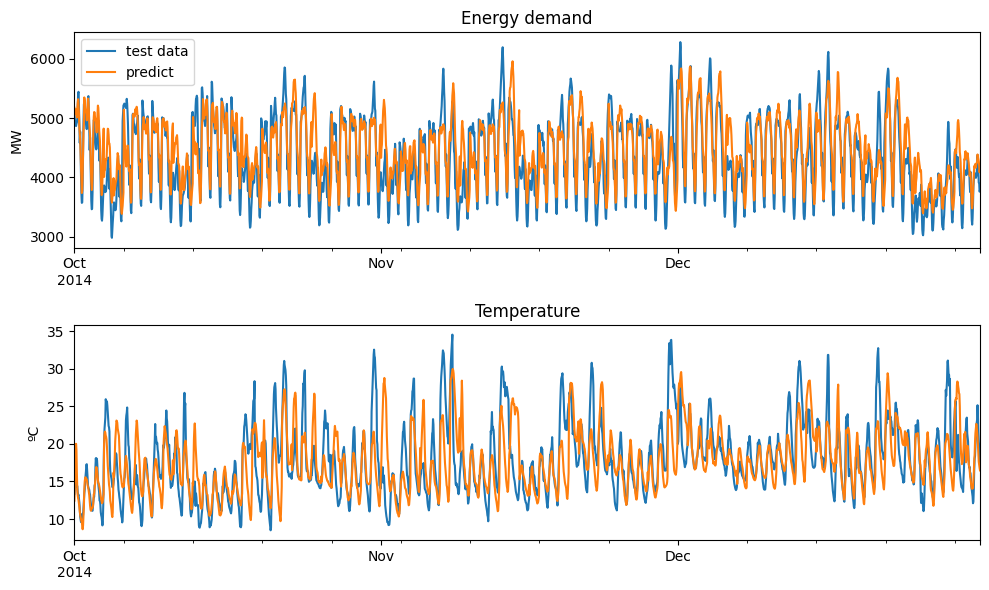

In [30]:
# Plot time series
# ==============================================================================
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

# data_train['Demand'].plot(label='train data', ax=axes[0])
data_test['Demand'].plot(label='test data', ax=axes[0])
predictions_all['Demand'].plot(label='predict', ax=axes[0])
axes[0].set_xlabel('')
axes[0].set_ylabel('MW')
axes[0].set_title('Energy demand')
axes[0].legend()

# data_train['Temperature'].plot(label='train data', ax=axes[1])
data_test['Temperature'].plot(label='test data', ax=axes[1])
predictions_all['Temperature'].plot(label='predict', ax=axes[1])
axes[1].set_xlabel('')
axes[1].set_ylabel('ºC')
axes[1].set_title('Temperature')

fig.tight_layout()
plt.show()

In [31]:
metric

,levels,mean_absolute_error
0,Demand,290.064649
1,Temperature,2.915335
2,average,146.489992
3,weighted_average,146.489992
4,pooling,146.489992


### Other option: SARIMA model
- https://skforecast.org/0.12.1/user_guides/forecasting-sarimax-arima


In [36]:
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
# ARIMA model with skforecast.Sarimax
# ==============================================================================
arima = Sarimax(order=(1, 1, 1))
arima.fit(y=data_train['Demand'])
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Demand   No. Observations:                24106
Model:               SARIMAX(1, 1, 1)   Log Likelihood             -163946.785
Date:                Mon, 30 Sep 2024   AIC                         327899.570
Time:                        12:00:10   BIC                         327923.841
Sample:                    12-31-2011   HQIC                        327907.440
                         - 09-30-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5145      0.008     61.340      0.000       0.498       0.531
ma.L1          0.1825      0.009     19.626      0.000       0.164       0.201
sigma2      4.746e+04    369.808    128.328      0.000    4.67e+04    4.82e+04
===================================================================================
Ljung-Box (L1) (Q):                   2.73   Jarque-Bera (JB):               760.39
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                            -0.13
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""